In [1]:

import sqlite3
import pandas as pd
from datetime import date 
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Conexão com o banco 
banco = sqlite3.connect("desafio-tecnico.db")
cur = banco.cursor()

In [3]:
# 1. Dados Das Contas  

query = cur.execute('''select 
	a.id, 
	a.account_number, 
	a.birth, 
	a.occupation, 
	a.email, 
	c.state,	
	c.city,
	b.level
from accounts a 
inner join address c on a.address_id = c.id 
left join levels b on a.account_number = b.account_number''').fetchall()


In [4]:
df_acc = pd.DataFrame(query, columns = ['id', 'account_number', 'birth', 'occupation', 'email', 'state', 'city', 'level'])

In [5]:
df_acc.head()

,id,account_number,birth,occupation,email,state,city,level
0,1,155938,1984-10-29,Outros,mariaceciliaazevedo042@example.com,RJ,Carmo,F
1,2,747007,1977-03-26,Corretor,ananunes3@example.com,MG,Bertopolis,D
2,3,208404,1984-01-26,Analista,luizfernandovieira@example.com,MG,Olaria,None
3,4,66402,1982-06-30,Investidor,gabriellynascimento6@example.com,PR,Icaraima,D
4,5,277012,1967-01-11,Outros,aliciagoncalves7@example.com,ES,Ecoporanga,D


In [6]:
# criando coluna idade
def calculate_age(born):
    born = datetime.strptime(born, "%Y-%m-%d").date()
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [7]:
df_acc['age'] = df_acc['birth'].apply(calculate_age)

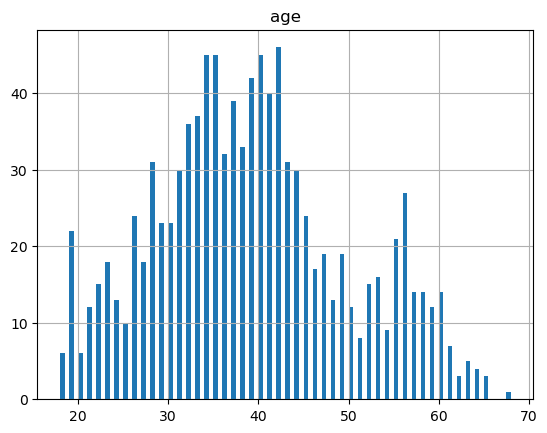

count    1029.000000
mean       39.031098
std        10.724032
min        18.000000
25%        32.000000
50%        38.000000
75%        45.000000
max        68.000000
Name: age, dtype: float64

In [8]:
# idade 

# conta a quantidade de ocorrências criando faixas de valores 
df_acc.hist(column='age', bins = 100)
plt.show()

df_acc['age'].describe()

In [9]:
# Occupation 

series = df_acc['occupation'].value_counts()
total_elements = series.sum()

df1 = pd.DataFrame(series)

df1['frequencia %'] = round(df1['occupation']*100 / total_elements,2) 

tabela_occup = pd.DataFrame({'occupation': df1.index,\
                       'Nº de contas': df1['occupation'],\
                           'Freq %': df1['frequencia %']})
    
tabela_occup.reset_index(inplace=True, drop=True)
print(tabela_occup)


      occupation  Nº de contas  Freq %
0       Analista           247   24.00
1  Desenvolvedor           221   21.48
2       Corretor           216   20.99
3         Outros           165   16.03
4     Investidor           117   11.37
5       Autonomo            63    6.12


In [10]:
# State 

series = df_acc['state'].value_counts()

df1 = pd.DataFrame(series)

df1['frequencia %'] = round(df1['state']*100 / total_elements, 2)

tabela_state = pd.DataFrame({'state': df1.index,\
                       'Nº de contas': df1['state'],\
                           'Freq %': df1['frequencia %']})
    
tabela_state.reset_index(inplace=True, drop=True)
print(tabela_state)


  state  Nº de contas  Freq %
0    MG           312   30.32
1    PR           215   20.89
2    RJ           170   16.52
3    ES           138   13.41
4    BA            53    5.15
5    SP            49    4.76
6    GO            47    4.57
7    SC            45    4.37


In [11]:
# Level 

series = df_acc['level'].value_counts()

total_elements = series.sum()

df1 = pd.DataFrame(series)

df1['frequencia %'] = round(df1['level']*100 / total_elements, 2)

tabela_level = pd.DataFrame({'level': df1.index,\
                       'Nº de contas': df1['level'],\
                           'Freq %': df1['frequencia %']})
    
tabela_level.reset_index(inplace=True, drop=True)

print(tabela_level)

  level  Nº de contas  Freq %
0     D           348   37.58
1     C           264   28.51
2     F           204   22.03
3     B            75    8.10
4     A            35    3.78


In [12]:

query = cur.execute('''
select 
	c.state, level, count() total
from accounts a 
inner join address c on a.address_id = c.id 
inner join levels b on a.account_number = b.account_number
group by c.state, level ''').fetchall()


tbl_state_level = pd.DataFrame(query, columns = ['state', 'level', 'total'])

agp = tbl_state_level.groupby(['state']).sum(numeric_only=True)

tbl_state_level = pd.merge(tbl_state_level, agp, on='state')

tbl_state_level['Frequencia %'] =  round(tbl_state_level['total_x']*100/ tbl_state_level['total_y'], 2)

print(tbl_state_level.head())

  state level  total_x  total_y  Frequencia %
0    BA     B        4       51          7.84
1    BA     C       20       51         39.22
2    BA     D       27       51         52.94
3    ES     A        7      121          5.79
4    ES     B       13      121         10.74


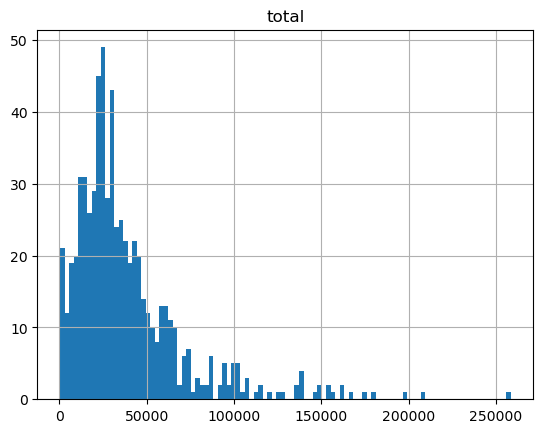

In [13]:

# transacoes por estado 

query = cur.execute('''
select 
	state,
	sum(c.value/100) as total,
	avg(c.value/100) as media
from accounts a 
inner join address b on a.address_id = b.id 
left join transactions c on a.account_number = c.account_number
group by b.city ''').fetchall()

df_transacoes = pd.DataFrame(query, columns = ['state', 'total', 'media'])

df_transacoes.hist(column='total', bins = 100)
plt.show()

In [14]:
# transacoes por mes

query = cur.execute('''
select 	
	(value/100) as value,
	created_at as date
from transactions
 ''').fetchall()

df_trans_mes = pd.DataFrame(query, columns = ['value', 'date'])

df_trans_mes['date'] = df_trans_mes['date'] .str[:7]

df_trans_mes = df_trans_mes.groupby(['date']).sum()

print(df_trans_mes)

           value
date            
2021-04  3924612
2021-05  8858519
2021-06  9328701
2021-07  3196210


In [15]:
# 2. Dados dos Boletos   

query = cur.execute('''select 
                        account_number,
                        status,
                        count(*) as count_charges, 
                        (sum(value)/100) as total_charges
                    from charges 
                    group by account_number, status
                    order by account_number''').fetchall()

df_charge = pd.DataFrame(query, columns = ['account_number', 'status', 'count_charges', 'total_charges'])


agp = df_charge.groupby(['account_number']).sum(numeric_only=True)

tbl_charge_status = pd.merge(df_charge, agp, on='account_number')

tbl_charge_status['Frequencia %'] =  round(tbl_charge_status['count_charges_x']*100/ tbl_charge_status['count_charges_y'], 2)

In [16]:
# filtrando os boletos pagos 
 
tbl_charge_paid = tbl_charge_status.loc[tbl_charge_status['status'] == 'paid'].copy()

tbl_charge_paid = tbl_charge_paid[['account_number', 'count_charges_x', 'total_charges_x', 'Frequencia %']]

tbl_charge_paid.rename(columns = {'count_charges_x': 'count_charges_paid', 'total_charges_x': 'total_charges_paid'\
                                         , 'Frequencia %': 'Perc_charges_paid'}, inplace = True)

In [17]:
    
# filtrando boletos não pagos 

tbl_charge_unpaid = tbl_charge_status.loc[tbl_charge_status['status'] == 'unpaid'].copy()

tbl_charge_unpaid = tbl_charge_unpaid[['account_number', 'count_charges_x', 'total_charges_x', 'Frequencia %']]

tbl_charge_unpaid.rename(columns = {'count_charges_x': 'count_charges_unpaid', 'total_charges_x': 'total_charges_unpaid',\
                                'Frequencia %': 'Perc_charges_unpaid'}, inplace = True)

In [18]:
# unificando dados 

df_unif_charge = pd.merge(tbl_charge_unpaid, tbl_charge_paid, on='account_number', how='outer')
df_unif_charge.head()

,account_number,count_charges_unpaid,total_charges_unpaid,Perc_charges_unpaid,count_charges_paid,total_charges_paid,Perc_charges_paid
0,2711,75.0,6805.0,34.25,144.0,12528.0,65.75
1,2763,95.0,5583.0,42.60,128.0,7575.0,57.40
2,2957,30.0,2664.0,48.39,32.0,2853.0,51.61
3,3478,18.0,614.0,50.00,18.0,633.0,50.00
4,5561,40.0,3518.0,60.61,26.0,2302.0,39.39


In [19]:
#transacoes por conta 

query = cur.execute('''select 
                    	a.account_number, 
                    	b.description,
                    	count(a.id) as count_trans,
                    	(sum(a.value)/100) as total_trans	
                    from transactions a 
                    inner join transaction_type b on a.transaction_type_id = b.id
                    group by a.account_number, b.description
                    order by account_number''').fetchall()
banco.close()
    
df_trans = pd.DataFrame(query, columns = ['account_number', 'description', 'count_trans', 'total_trans'])
  
agp = df_trans.groupby(['account_number']).sum(numeric_only=True)

tbl_trans = pd.merge(df_trans, agp, on='account_number')

tbl_trans['Frequencia %'] =  round(tbl_trans['count_trans_x']*100/ tbl_trans['count_trans_y'], 2)

In [20]:

# filtrando as transacoes br - boleto_recebido
 
tbl_trans_br = tbl_trans.loc[tbl_trans['description'] == 'boleto_recebido'].copy()

tbl_trans_br = tbl_trans_br[['account_number', 'total_trans_x', 'Frequencia %']]

tbl_trans_br.rename(columns = {'total_trans_x': 'total_trans_blt_rec'\
                                         , 'Frequencia %': 'Perc_blt_rec'}, inplace = True)

In [21]:
# filtrando as transacoes pxe - pix_enviado
 
tbl_trans_pxe = tbl_trans.loc[tbl_trans['description'] == 'pix_enviado'].copy()

tbl_trans_pxe = tbl_trans_pxe[['account_number', 'total_trans_x', 'Frequencia %']]

tbl_trans_pxe.rename(columns = {'total_trans_x': 'total_trans_pix_env'\
                                         , 'Frequencia %': 'Perc_pix_env'}, inplace = True)


In [22]:
# filtrando as transacoes pxr - pix_recebido
 
tbl_trans_pxr = tbl_trans.loc[tbl_trans['description'] == 'pix_recebido'].copy()

tbl_trans_pxr = tbl_trans_pxr[['account_number', 'total_trans_x', 'Frequencia %']]

tbl_trans_pxr.rename(columns = {'total_trans_x': 'total_trans_pix_rec'\
                                         , 'Frequencia %': 'Perc_pix_rec'}, inplace = True)


In [23]:
## unificando dados 

df_unif_trans = pd.merge(tbl_trans_br, tbl_trans_pxe, on='account_number', how='outer')
df_unif_trans = pd.merge(df_unif_trans, tbl_trans_pxr, on='account_number', how='outer')    
    

In [24]:
df = df_acc.copy()

df = df[['account_number', 'level']]

df = pd.merge(df, df_unif_charge, on='account_number', how='left')
df = pd.merge(df, df_unif_trans, on='account_number', how='left')
df['total_trans'] = df['total_trans_blt_rec'] + df['total_trans_pix_rec'] + df['total_trans_pix_env']

df.head()

,account_number,level,count_charges_unpaid,total_charges_unpaid,Perc_charges_unpaid,count_charges_paid,total_charges_paid,Perc_charges_paid,total_trans_blt_rec,Perc_blt_rec,total_trans_pix_env,Perc_pix_env,total_trans_pix_rec,Perc_pix_rec,total_trans
0,155938,F,39.0,4313.0,56.52,30.0,3424.0,43.48,3424.0,27.03,10166.0,13.51,7546.0,59.46,21136.0
1,747007,D,153.0,5126.0,57.52,113.0,3752.0,42.48,3752.0,38.31,6252.0,3.39,5667.0,58.31,15671.0
2,208404,None,79.0,4262.0,55.24,64.0,3497.0,44.76,3497.0,28.07,11756.0,3.51,8606.0,68.42,23859.0
3,66402,D,33.0,2474.0,15.21,184.0,13410.0,84.79,13410.0,51.83,13211.0,1.41,12214.0,46.76,38835.0
4,277012,D,112.0,5695.0,55.45,90.0,4553.0,44.55,4553.0,34.88,11536.0,3.49,7967.0,61.63,24056.0
